In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sys
sys.path.append('..')
from dataset import batcher

In [187]:
MODEL_DIR = '../saved_models/'
LR_RATE = 0.0001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [222]:
# Get test split
bands = ['CO']
# bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SW_IR1', 'SW_IR2', 'TEMP', 'VIIRS', 'DELTA_TEMP', 'CO']
test_batcher = batcher.Batcher(bands, country_year='malawi-2016', bucket=False, shuffle=False, split='custom', repeat=1, batch_size=3511).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 652, 224, 224, 1)


In [223]:
# Load model
experiments = ['imagery_sample_cnn_regression_CO']

def load_model_from_dir(model_name):
    model_path = MODEL_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [224]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
    loss=LOSS,
    optimizer=OPT,
    metrics=METRICS,
)

y_preds = trained_model.predict(x_true)
print(y_preds)

2023-02-26 10:33:17.236869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 3s 117ms/step
[[-0.9584618 ]
 [-1.3149124 ]
 [-0.6754068 ]
 [-1.4248035 ]
 [-1.0000545 ]
 [-0.50389606]
 [-0.7198823 ]
 [-0.75414085]
 [-0.7069136 ]
 [-0.9285059 ]
 [-0.9222338 ]
 [-1.0225171 ]
 [-0.5849696 ]
 [-0.5356736 ]
 [-0.61312973]
 [-0.5446923 ]
 [-0.54008704]
 [ 0.02109383]
 [-1.2571111 ]
 [-0.9539398 ]
 [-0.33653122]
 [-0.55157197]
 [-0.7069136 ]
 [-0.7930224 ]
 [-0.58675265]
 [-0.57950866]
 [-0.4802953 ]
 [ 0.00948146]
 [-0.5730333 ]
 [-1.1855049 ]
 [-0.40817508]
 [-1.0186085 ]
 [-0.7964398 ]
 [-1.4040128 ]
 [-0.47657958]
 [-0.56484675]
 [-0.6166473 ]
 [-1.4709913 ]
 [ 0.00948146]
 [-0.5879951 ]
 [-0.59653   ]
 [-0.6000248 ]
 [-0.5165641 ]
 [-0.5170848 ]
 [-1.0909145 ]
 [-0.5628315 ]
 [-0.8199378 ]
 [-0.58540094]
 [-0.58573115]
 [-0.6176462 ]
 [-0.27258822]
 [-0.7935901 ]
 [-1.4768132 ]
 [-0.54008704]
 [-0.34284672]
 [-0.7935901 ]
 [-0.33952788]
 [-0.35968295]
 [-0.51572573]
 [-0.99330384]
 [-0.26677412]
 [-1.1855049 ]
 [-0.8817068 ]


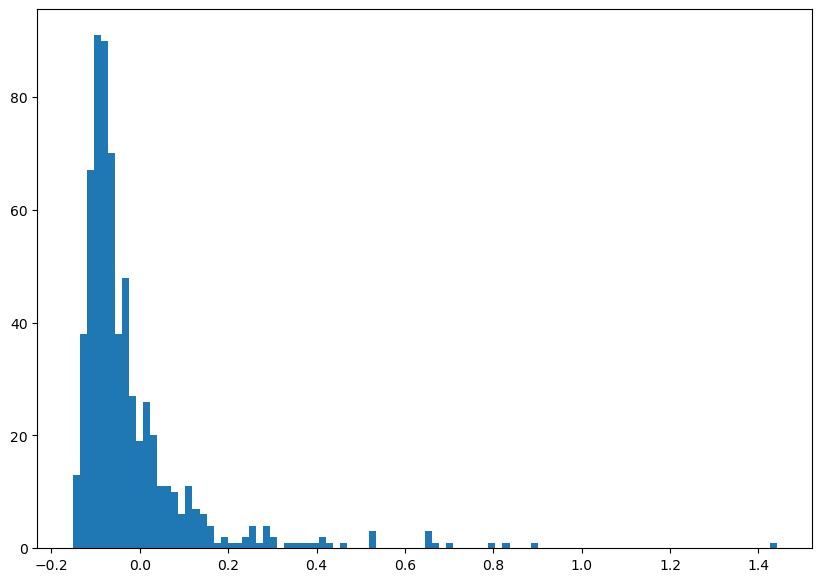

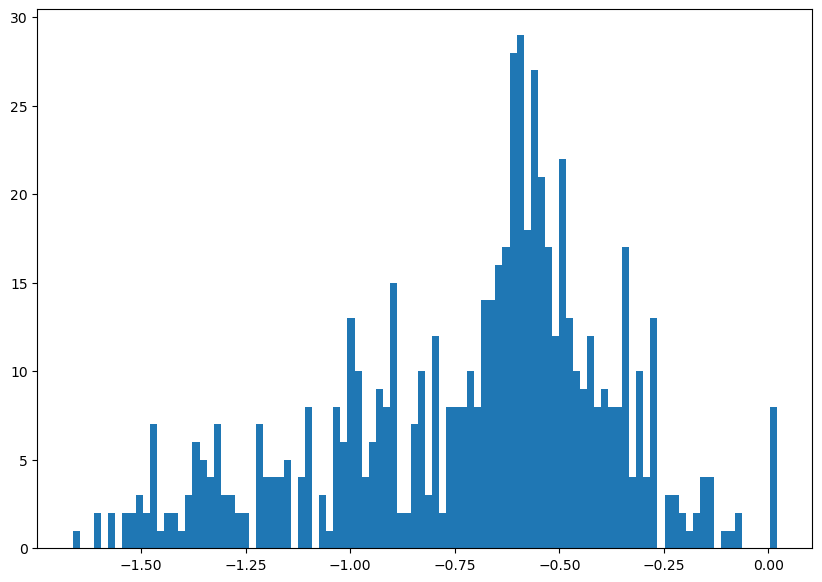

In [225]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()

y_true = 2 * ((y_true - min(y_true)) / (max(y_true) - min(y_true))) - 1
y_preds =2 * ((y_preds - min(y_preds)) / (max(y_preds) - min(y_preds))) - 1


r2 = pearsonr(y_true, y_preds)[0]

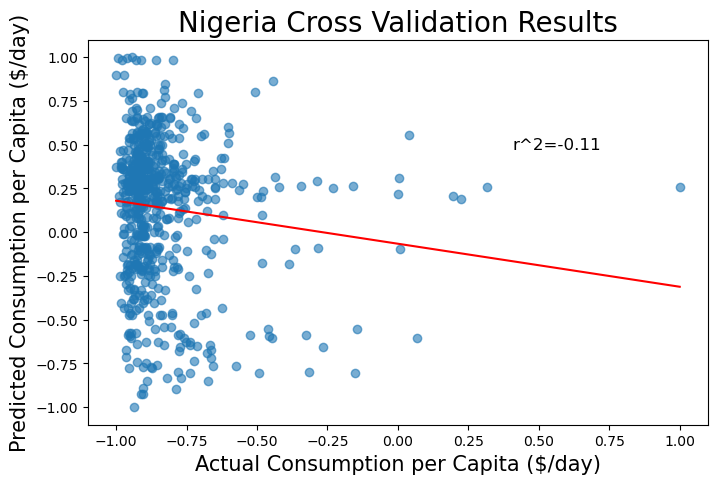

In [226]:
# Plot predictions
country = 'Nigeria'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
# plt.xlim([np.min(y_true), 10])
# plt.ylim([np.min(y_true), 10])
plt.show()